# Initial guess algorithm in adiabatic quantum computing simulations
---

## Reading materials 
1. Quantum Optimization for Maximum Independent Set Using Rydberg Atom Arrays - Hannes Pichler
2. Lecture 32: Luby’s Algorithm for Maximal Independent Set - Gary Miller
3. A study of heuristic guesses for adiabatic quantum computation - Alejandro Perdomo-Ortiz

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
# The library for quantum adiabatic simulations.
from qutip import * 
from scipy import *
# The library used for the graph representation.  
import networkx as nx
from guess_algorithm_helper import *
from random import randint


## Researched Algorithes

In this notebook I will compare 3 different approaches to solve MIS (Maximum independent sets).

Our goal is to create hamiltonians that solve MIS in diffrent ways and compare them to show ours is best.
To do so the basic hamiltonian class we need to implement is:

In [15]:
class BaseHamiltonian:
    """
    Base class for Hamiltonian objects. Handles the creation of common operators, 
    distance calculations, and general Hamiltonian solving logic.

    Parameters:
    params (dict): A dictionary of parameters including the blockade radius, interaction strength, etc.
    graph_instance (Graph): A graph instance containing nodes and positions for the system.
    """
    
    def __init__(self, params, graph_instance):
        """
        Initializes the Hamiltonian base class with system parameters and graph information.

        Args:
        params (dict): Dictionary of system parameters.
        graph_instance (Graph): Instance of a graph representing the system.
        """
        self.params = params
        self.graph = graph_instance.graph
        self.N = len(self.graph.nodes)
        self.sx_list, self.sz_list, self.one_list, self.I_N = self.generate_operators()

    def create_hamiltonians(self):
        """
        Define Hamiltonians. Must be implemented in subclasses.
        """
        raise NotImplementedError("This method should be implemented in subclasses.")
    
    def generate_operators(self):
        """
        Generates the Pauli operators (sx, sz) and identity operators for each site in the system.

        Returns:
        tuple: A tuple containing the lists of operators (sx_list, sz_list, one_list) and the identity operator (I_N).
        """
            # Identity and Pauli-like operators for given number of states
        si = qeye(2)  # Identity matrix for a `num_states`-dimensional system

        # Define generalizations for Pauli matrices
        
        sx = sigmax()
        sz = sigmaz()
        one = basis(2, 1)  # |1><1| for qubit
        # Initialize empty lists for storing operators
        sx_list = []
        sz_list = []
        one_list = []

        # Identity tensor for N states
        I_N = tensor([si] * self.N)

        # Generate the operators
        for n in range(self.N):
            # Initialize a list of identities for the tensor product
            op_list = [si] * self.N

            # Replace the n-th position with sx, sz, or |1><1|
            op_list[n] = sx
            sx_list.append(tensor(op_list))

            op_list[n] = 0.5 * (si - sz)
            sz_list.append(tensor(op_list))

            op_list[n] = one * one.dag()
            one_list.append(tensor(op_list))

        return sx_list, sz_list, one_list, I_N

    def initialize_state(self, custom_state=None):
        """
        Initializes the state vector for the system. Uses a default state unless a custom state is provided.

        Args:
        custom_state (Qobj, optional): A custom state vector. If None, the default state is used.

        Returns:
        Qobj: The initial state vector for the system.
        """
        if custom_state is None:
            # Default state: all qubits in the |0> state
            return qutip.tensor([qutip.basis(2, 0) for _ in range(self.N)])
        return custom_state

    def create_interaction_term(self):
        """
        Creates the interaction Hamiltonian for the system.

        Returns:
        Qobj: The interaction Hamiltonian H_int.
        """

        # Interaction Hamiltonian (H_int)
        H_int = 0
        for v in range(self.N):
            for w in range(v + 1, self.N):
                if (v, w) in self.graph.edges:
                    dist = self.params["blockade_radius"] * self.params['vertex_placement']
                else:
                    dist = self.params["blockade_radius"] * 3 * (1 / self.params['vertex_placement'])

                H_int += self.params["INTERACTION_STRENGTH"] / dist**6 * self.one_list[v] * self.one_list[w]

        return H_int

    def solve(self):
        """
        Solves the Hamiltonian system using the `sesolve` function.
        
        Returns:
        tuple: A tuple containing the Hamiltonian in time-dependent form and the result of solving it.
        """
        h_t = QobjEvo(self.create_hamiltonian())
        result = sesolve(h_t, self.initialize_state(), self.params['taulist'])
        return h_t, result

## Normal - The known algorithm using Rydbeg atoms

We simply use the algorithm that's described by Hannes Pichler:
$$\begin{cases}
H_0 = \sum_{n=1}^NI - \sigma_x^n \\
H_p = -\Delta n_v \\
H_{int} = \sum_{v<w}V/x^6(|\vec{x}_v-\vec{x}_w|)n_vn_w
\end{cases}
$$

Using that we can build a full hamiltonian:
$$H_{tot} = H_0 \Omega(t) + H_p\Delta(t) + H_{int}$$


In [16]:
class HarvardHamiltonian(BaseHamiltonian):
    def create_hamiltonian(self):
        # Base class already calculates the interaction Hamiltonian (H_int)
        H_int = self.create_interaction_term()

        # Specific terms for this Hamiltonian
        CL_H0 = self.I_N - sum(self.sx_list)  # Example term for the Hamiltonian
        Hp = -sum(self.one_list)  # Example term for the Hamiltonian

        # Return the Hamiltonian in the required format
        return [[CL_H0, self.params['Omega']], [Hp, self.params['Delta']], H_int]



## Heuristic Guess

As the name suggests we add a heuristic guesses for each vertex based on it's degree in the graph.

The new initial hamiltonian is as follows:
$$\tilde{H}_0 = \sum_{n=1}^{N}\left(x_n \hat{I}+ \hat{q}_n(1-2x_n)\right) + \delta\sum_{n=1}^{N}\sigma_x^n$$

With $x_n$ being the guess:

$$x_n=\begin{cases}
1\rangle & & \frac{1}{dv} \geq C\\ 
0 \rangle & & \frac{1}{dv} < C
\end{cases}$$

and $\hat{q}_n$ is  $$\hat{q}_n = \hat{I}_N \otimes\hat{I}_{N-1} \otimes \dots \otimes \frac{1}{2}(\hat{I}-\sigma_z^n)\otimes \dots \otimes I_1$$


Finally $dv$ is the degree of vertex v, and constant $C \in [0,1]$ defines which vertex is assumed to start at ground and which is assumed to start at Rydberg. 

**_NOTE:_** We don't want divergance in out initial guess, which will happen if two adjacent vertex are drawn to Rydberg. For step I, our way to solve this is to set $C=1$. Meaning that only if the vertex is a leaf, it will start at Rydberg. Of course no two leafs are adjacent so no divergance will accure. 

In fact we can prove easly that all leafs can always be in the MIS. 
Assuming that there is a leaf v and an MIS G that doesn't contain v, since $G \cup v$ is a bigger graph and isn't the MIS, the vertex k that's connected to v must be in G. We can create a new graph $G'$ which is the same as G but with v instead of k. That is clearly also an MIS of same size.


In [17]:
def huristic_guess(graph,sx_list, sz_list, I_N, DEGREE_MIN, guess_func,delta):
    """
    Parameters:
    - graph: Graph object to get node properties.
    - sx_list,sz_list, I_N: Precomputed operator lists.
    - DEGREE_MIN: Minimum degree for guess calculation.
    - guess_func: Function for generating guesses based on graph node properties.
    - delta: The delta value for the Hd term.
    Returns:
    - GU_H0
    """
    N = len(graph.nodes)
    GU_H0 = 0
    Hd = 0  # Initialize Hd to 0
    guesses = [guess_func(graph, n, DEGREE_MIN) for n in range(N)]

    for n, guess in enumerate(guesses):
        GU_H0 += guess * I_N + sz_list[n] * (1 - 2 * guess)
        Hd += delta * sx_list[n]

    return GU_H0, Hd

And the hamiltonian is similiar
$$H_{tot} = \hat{H}_0 \Omega(t) + H_p\Delta(t) + H_{int}$$

In [18]:
class SombreroHamiltonian(BaseHamiltonian):
    def __init__(self, params, graph_instance, guess_func):
        super().__init__(params, graph_instance)
        self.guess_func = guess_func

    def create_hamiltonian(self):
        H_int = self.create_interaction_term()
        Hp = -sum(self.one_list)
        GU_H0,Hd = huristic_guess(
            self.graph, self.sx_list, self.sz_list, self.I_N, self.params['DEGREE_MIN'], self.guess_func, self.params['delta'])
        # Return the Hamiltonian in the required format
        return [[GU_H0, self.params['Omega']], [Hd, self.params['Omega']], [Hp, self.params['Delta']], H_int]


## Our algorithm

As Adi suggested, using an initial setup on $|\psi_0 \rangle$ could result in better complexity.
As a follow up from the Heuristic Guess we can set it up as follows:
 $$|\psi_0 \rangle=\begin{cases}
|r\rangle & & \frac{1}{dv} \geq C\\ 
|g \rangle & & \frac{1}{dv} < C
\end{cases}$$

However since the corrent Hamiltonian aspires for grounds states at the start, we need to change it.
The algorithm we decided to test is:

$$H'_{tot} = (1-s)\sum_{n=1}^{N} \Delta_0 \left(x_n \hat{I}+ \hat{q}_n(1-2x_n)\right) + \Omega(t)\delta\sum_{n=1}^{N}\sigma_x^n -s\Delta_0 n_v+H_{int}$$


In [19]:
class GuessHamiltonian(BaseHamiltonian):
    def __init__(self, params, graph_instance, guess_func):
        super().__init__(params, graph_instance)
        self.guess_func = guess_func

    def create_hamiltonian(self):
        H_int = self.create_interaction_term()
        Hp = -sum(self.one_list)
        GU_H0,Hd = huristic_guess(
            self.graph, self.sx_list, self.sz_list, self.I_N, self.params['DEGREE_MIN'], self.guess_func, self.params['delta'])
        return [
            [self.params['DELTA_0'] * GU_H0, lambda t: 1 - t / self.params['TAU_MAX']],  # Time-dependent term for GU_H0
            [Hd, self.params['Omega']],  # Static term for Hd
            [self.params['DELTA_0'] * Hp, lambda t: t / self.params['TAU_MAX']],  # Time-dependent term for Hp
            H_int  # Interaction term
        ]

    def initialize_state(self):
        guesses = [
            qutip.basis(2, 1) if self.guess_func(self.graph, n, self.params['DEGREE_MIN']) else qutip.basis(2, 0)
            for n in range(self.N)
        ]
        return qutip.tensor(guesses)

---

## Parameters

### Hamiltonian parameters

Using page 4 of the article, we know the detuning ($\Delta(t)$) ,rabi frequency ($\Omega(t)$) and the rabi blockade radius($r_B$). 
$$\Delta(t) = \Delta_0 (2t/T-1)  $$
 $$ \Omega(t) = \Omega_0 sin^2(\pi t/T)$$
$$r_B = \left(C/\sqrt{(2\Omega)^2+\Delta^2}\right)^{1/6}$$

Where C is the interuction strength of rydberg atoms. We also use $\Omega_0 = 1$ and $\Delta_0/\Omega_0 = 6$.

To get the scale of the required T to finish the adiabatic transformation, we can look at different finish times:  
$$T = 5/\Omega_0 , 10/\Omega_0 ,\dots$$

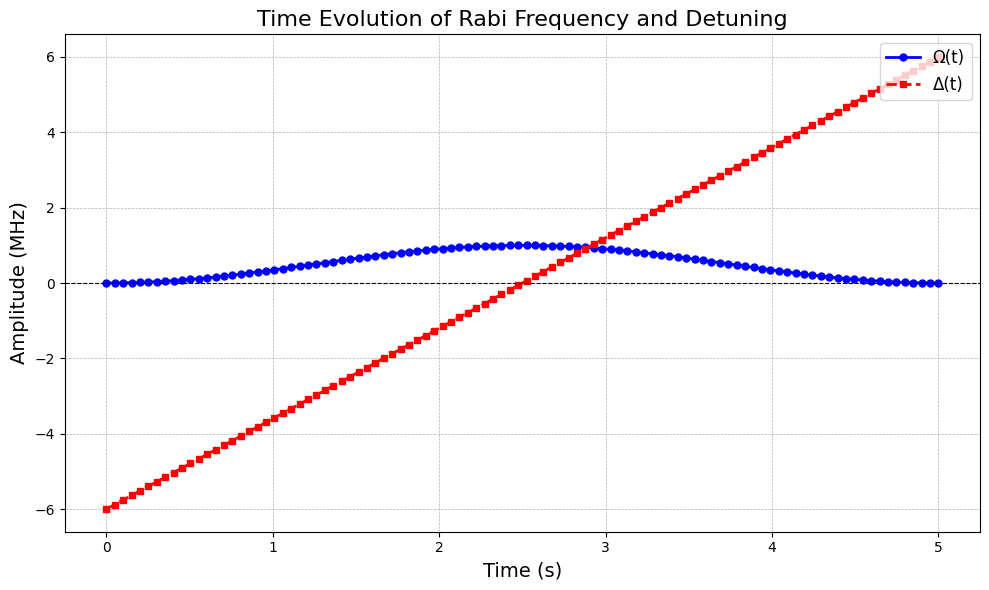

In [20]:
def initialize_system_parameters(delta=1.5, degree_min=1, omega_0 = 1, tau_max = 5, vertex_placement = 1):
    """
    Initializes the system parameters and returns the blockade radius, time-dependent 
    functions for Omega and Delta, and other constants.
    
    Parameters:
    delta (float): Power of driving Hamiltonian
    degree_min (float): Minimum degree threshold for the graph
    OMEGA_0 (float): Base Rabi frequency
    tau_max(float): in units of omega_0, the size of TAU_MAX
    vertex_placement(float): between 0 and 1, how close are vertexes to be placed near eachother.
                                      Note that this increases computation as it gets smaller. 
    
    Returns:
    dict: A dictionary containing time-dependent functions and system parameters
    """
    DELTA_0 = 6 / omega_0  # Initial detuning
    TAU_MAX = tau_max / omega_0  # Maximum time (in units of omega_0)
    INTERACTION_STRENGTH = 8.6 * omega_0  # Interaction strength constant

    # Calculate blockade radius
    blockade_radius = round((INTERACTION_STRENGTH * omega_0 / np.sqrt((2 * omega_0) ** 2 + DELTA_0 ** 2)) ** (1 / 6), 10)
    
    # Define time points for plotting
    taulist = np.linspace(0, TAU_MAX, 100)
    
    # Time-dependent Rabi frequency (Ω)
    def Omega(t):
        return omega_0 * np.sin(np.pi * t / TAU_MAX) ** 2
    
    # Time-dependent detuning (Δ)
    def Delta(t):
        return DELTA_0 * (2 * t / TAU_MAX - 1)
    
    # Return all parameters in a dictionary
    return {
        "OMEGA_0": omega_0,
        "DELTA_0": DELTA_0,
        "TAU_MAX": TAU_MAX,
        "INTERACTION_STRENGTH": INTERACTION_STRENGTH,
        "blockade_radius": blockade_radius,
        "vertex_placement": vertex_placement,
        "taulist": taulist,
        "Omega": Omega,
        "Delta": Delta,
        "delta": delta,
        "DEGREE_MIN": degree_min
    }

# Initialize system parameters
init_params = initialize_system_parameters(vertex_placement = 0.8)

# Example usage: Plotting the time evolution of Omega and Delta
timeEvoPlot(init_params["taulist"], init_params["Omega"], init_params["Delta"])

### Choosing a Graph

Since our system for checking complexity assumes there is little divergence, we use a chain graph as a basic test.

Note that in an actual system, another code needs to be written for transforming any graph to a real placement on the chip. Since this is not an easy code and isn't the basis of our research I am creating the graphs after we place them already.

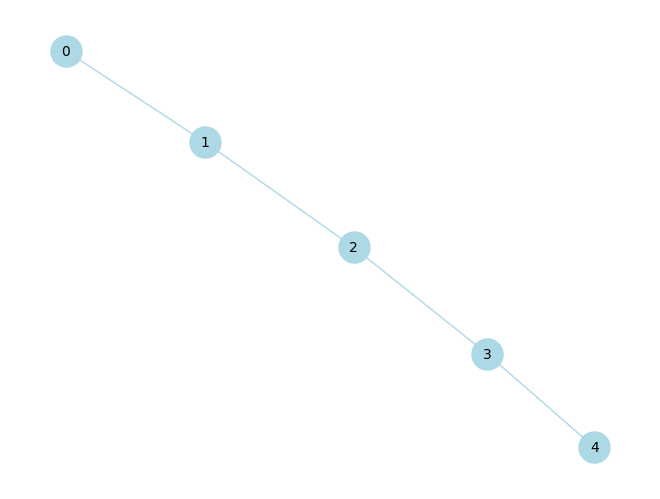

In [21]:
class BaseGraph:
    """Base class for graph generation."""
    
    def __init__(self, N):
        self.N = N
        self.graph = nx.Graph()
        self.pos = None  # Default position is None; subclasses can set it

    def plot_graph(self, ax=None, color = 'lightblue'):
        """Plots the generated graph on a given axis."""
        if self.pos is None:
            self.pos = nx.spring_layout(self.graph)  # Use spring layout if no position is set
        nx.draw(self.graph, pos=self.pos, with_labels=True, ax=ax, node_color=color, edge_color=color, node_size=500, font_size=10)
        if (ax != None):
            ax.set_title(self.__class__.__name__)  # Set title to class name

class ChainGraph(BaseGraph):
    """Class for generating a chain graph."""
    
    def __init__(self, N):
        super().__init__(N)

    def create_graph(self):
        """Creates a chain graph and adds edges based on blockade radius."""
        for i in range(self.N-1):
            self.graph.add_edge(i,i+1)



# Example usage:
N = 5  # Change N to test different cases
chain_graph = ChainGraph(N)
chain_graph.create_graph()
chain_graph.plot_graph()

### Building the hamiltonians


In [22]:
def default_guess_function(graph, node_index, degree_min):
    """Default guess function based on node degree."""
    if len(graph.degree)==2:
        return node_index==0
    return 1 / max(1, graph.degree[node_index]) >= degree_min

def hamiltonians_constructor(params,graph,guess_func = default_guess_function):
    # Initialize Hamiltonians
    harvard_hamiltonian = HarvardHamiltonian(params, graph)
    sombrero_hamiltonian = SombreroHamiltonian(params, graph, guess_func)
    guess_hamiltonian = GuessHamiltonian(params, graph, guess_func)

    # Solve each Hamiltonian
    harvard_h_t, harvard_result = harvard_hamiltonian.solve()
    sombrero_h_t, sombrero_result = sombrero_hamiltonian.solve()
    guess_h_t, guess_result = guess_hamiltonian.solve()

    # Consolidate results
    hamiltonians_out = {
        "harvard": harvard_h_t,
        "sombrero": sombrero_h_t,
        "guess": guess_h_t,
    }

    results_out = {
        "harvard": harvard_result,
        "sombrero": sombrero_result,
        "guess": guess_result,
    }
    return hamiltonians_out, results_out
hamiltonians_out,results_out = hamiltonians_constructor(init_params,chain_graph,default_guess_function)

## Results analysis

### Minimal gap 

In MIS usually a miniamal gap is not a good indication of complexity since there will be divergence. However in simple chain graphs it can still be an indication.

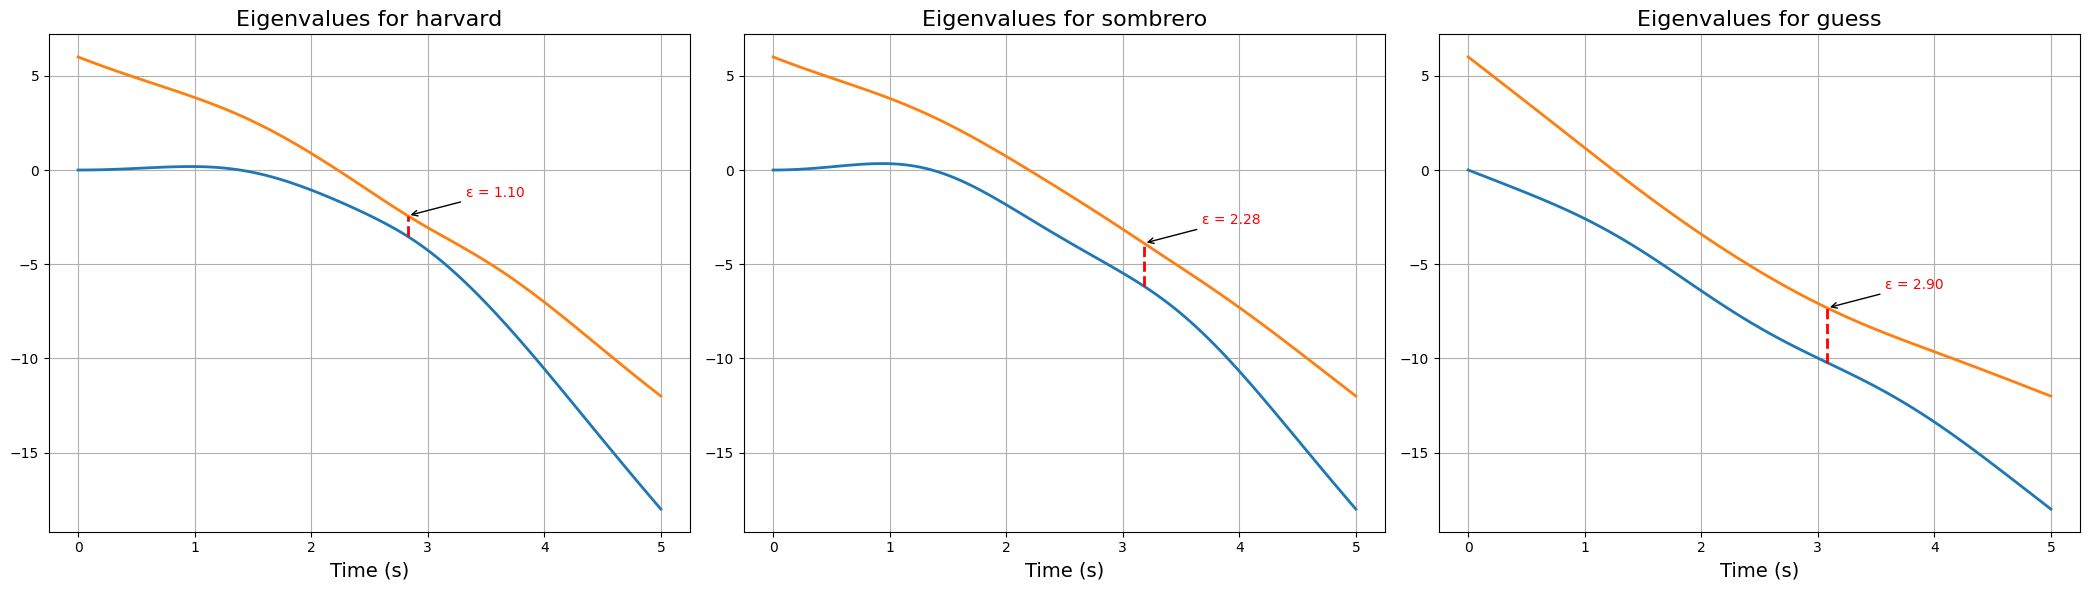

In [23]:
def plot_eigenvalues(taulist, hamiltonians, N, M=2):
    """Plots eigenvalues for the given Hamiltonians over time in a compact format."""
    eigenvalues = {key: np.zeros((len(taulist), 2**N)) for key in hamiltonians.keys()}

    for key in hamiltonians:
        for i, t in enumerate(taulist):
            H = hamiltonians[key](t)
            eigenvalues[key][i, :] = H.eigenenergies()

    fig, axs = plt.subplots(1, 3, figsize=(21, 6))

    for ax, key in zip(axs, hamiltonians.keys()):
        for m in range(M):
            ax.plot(taulist, eigenvalues[key][:, m], label=f"Eigenvalue {m}", linewidth=2)

        lowest_eigenvalues = eigenvalues[key][:, :2]
        gap_values = lowest_eigenvalues[:, 1] - lowest_eigenvalues[:, 0]
        epsilon = np.min(gap_values)
        gap_time_index = np.argmin(gap_values)

        ax.plot([taulist[gap_time_index]] * 2,
                [lowest_eigenvalues[gap_time_index, 0], lowest_eigenvalues[gap_time_index, 1]],
                color='red', linestyle='--', linewidth=2, label='Minimal Gap ε')

        ax.annotate(f'ε = {epsilon:.2f}', 
                     xy=(taulist[gap_time_index], lowest_eigenvalues[gap_time_index, 0] + epsilon),
                     xytext=(taulist[gap_time_index] + 0.5, lowest_eigenvalues[gap_time_index, 0] + epsilon + 1),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),
                     fontsize=10, color='red')

        ax.set_title(f'Eigenvalues for {key}', fontsize=16)
        ax.set_xlabel('Time (s)', fontsize=14)
        # ax.legend(fontsize=12)
        ax.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_eigenvalues(init_params["taulist"], hamiltonians_out,N, M=2)

And clearly Our hamiltonian was the best :)

### States comparing
I gave the sytem a small time frame for the problem. Hence no algorithm is done solving it yet. Using that we can see the difference in how each of them works.

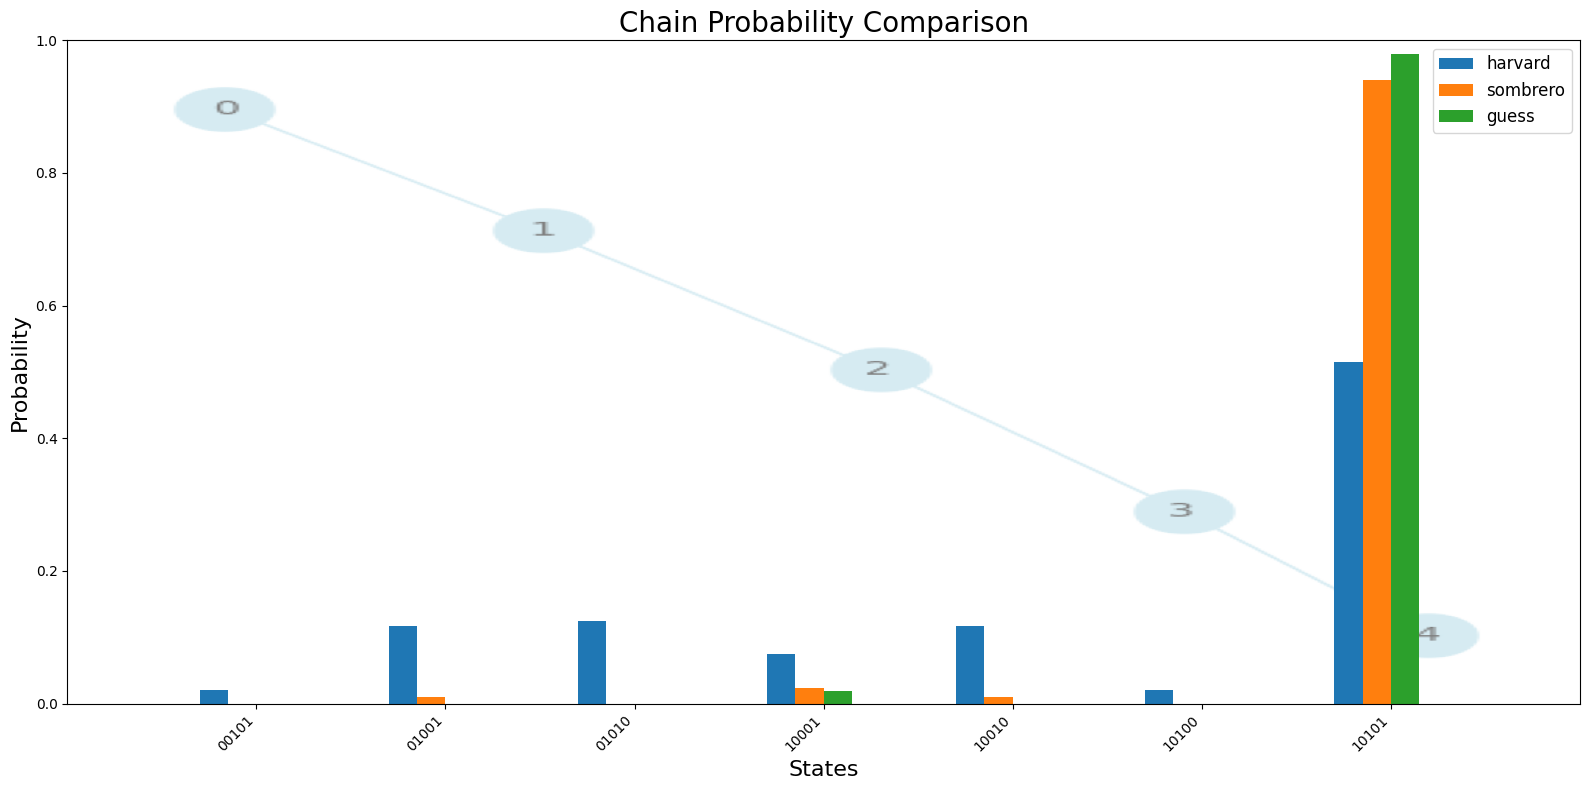

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from io import BytesIO

def get_background_image(background_graph):
    """Creates a background image from the graph without saving to disk."""
    fig, ax = plt.subplots(figsize=(6, 6))
    background_graph.plot_graph()
    plt.axis('off')
    
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', transparent=True)
    plt.close(fig)
    buf.seek(0)
    return buf

def transform_states_to_binary(states):
    """Transform states into binary representation."""
    return [
        ''.join('0' if char in '01' else '1' for char in state)
        for state in states
    ]

def compute_new_probabilities(original_probs, transformed_states):
    """Combine probabilities of identical transformed states."""
    prob_dict = {}
    for state, prob in zip(transformed_states, original_probs):
        prob_dict[state] = prob_dict.get(state, 0) + prob
    return prob_dict

def plot_probabilities(results_out, N, graph_type, graph=None, threshold=0.1, merge_states_flag=True):
    """
    Plot probabilities for given results, ensuring the threshold is applied after merging states.

    Parameters:
    - results_out (dict): Results for different Hamiltonians.
    - N (int): Number of qubits/nodes in the graph.
    - graph_type (str): Type of graph (e.g., "Chain").
    - graph (optional): Background graph object.
    - threshold (float): Minimum probability to consider.
    - merge_states_flag (bool): Whether to merge states or keep distinct.
    """
    # Initialize a global set of states across all results
    global_states = set()

    # Process each Hamiltonian to extract and merge states
    for result in results_out.values():
        num_states = result.states[-1].dims[0][0]
        try:
            all_states = [
                ''.join(map(str, combination)) for combination in product(range(num_states), repeat=N)
            ]
        except ValueError:
            raise ValueError(f"Invalid num_states={num_states} for N={N}. Check results consistency.")
        
        coeffs = [np.abs(a_i[0])**2 for a_i in result.states[-1].full()]
        relevant_indices = np.where(np.array(coeffs) > 0)[0]  # Select all initially
        relevant_states = [all_states[idx] for idx in relevant_indices if idx < len(all_states)]
        relevant_coeffs = [coeffs[idx] for idx in relevant_indices if idx < len(all_states)]

        if num_states == 3 and merge_states_flag:
            # Merge states into binary representations
            transformed_states = transform_states_to_binary(relevant_states)
            merged_probs = compute_new_probabilities(relevant_coeffs, transformed_states)

            # Apply threshold after merging
            filtered_states = {state: prob for state, prob in merged_probs.items() if prob > threshold}
            global_states.update(filtered_states.keys())
        else:
            # Apply threshold without merging
            filtered_states = {
                state: prob for state, prob in zip(relevant_states, relevant_coeffs) if prob > threshold
            }
            global_states.update(filtered_states.keys())

    # Create a sorted list of global states
    global_states = sorted(global_states)

    # Prepare probabilities for each Hamiltonian in alignment with global states
    final_probs = {key: [0] * len(global_states) for key in results_out.keys()}

    for key, result in results_out.items():
        num_states = result.states[-1].dims[0][0]
        try:
            all_states = [
                ''.join(map(str, combination)) for combination in product(range(num_states), repeat=N)
            ]
        except ValueError:
            continue  # Skip this result if num_states is invalid

        coeffs = [np.abs(a_i[0])**2 for a_i in result.states[-1].full()]
        relevant_indices = np.where(np.array(coeffs) > 0)[0]  # Select all initially
        relevant_states = [all_states[idx] for idx in relevant_indices if idx < len(all_states)]
        relevant_coeffs = [coeffs[idx] for idx in relevant_indices if idx < len(all_states)]

        if num_states == 3 and merge_states_flag:
            # Merge states and probabilities
            transformed_states = transform_states_to_binary(relevant_states)
            merged_probs = compute_new_probabilities(relevant_coeffs, transformed_states)

            # Apply threshold after merging
            for state, prob in merged_probs.items():
                if state in global_states and prob > threshold:
                    final_probs[key][global_states.index(state)] = prob
        else:
            # Apply threshold directly
            for state, prob in zip(relevant_states, relevant_coeffs):
                if state in global_states and prob > threshold:
                    final_probs[key][global_states.index(state)] = prob

    # Plot probabilities
    plt.figure(figsize=(16, 8))
    ax = plt.gca()

    if graph is not None:
        buf = get_background_image(graph)
        background_img = plt.imread(buf)
        ax.imshow(background_img, aspect='auto', extent=[-1, len(global_states), 0, 1], alpha=0.5)

    bar_width = 0.15
    x = np.arange(len(global_states))

    for i, (label, probs) in enumerate(final_probs.items()):
        ax.bar(x + (i - len(final_probs) / 2) * bar_width, probs, width=bar_width, label=label)

    ax.set_title(f"{graph_type} Probability Comparison", fontsize=20)
    ax.set_xlabel("States", fontsize=16)
    ax.set_ylabel("Probability", fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(global_states, rotation=45, ha='right', fontsize=10)
    ax.legend(fontsize=12)
    plt.tight_layout()
    plt.show()
# Example usage
# Assuming results_out and chain_graph are defined
plot_probabilities(
    results_out=results_out,
    N=5,
    graph_type="Chain",
    graph=chain_graph,
    threshold=0.01,
    merge_states_flag=True
)


---
# A proper guess function
We can use a greedy algorithm to build an independent set. This needs to be improved to be in polumomial time.

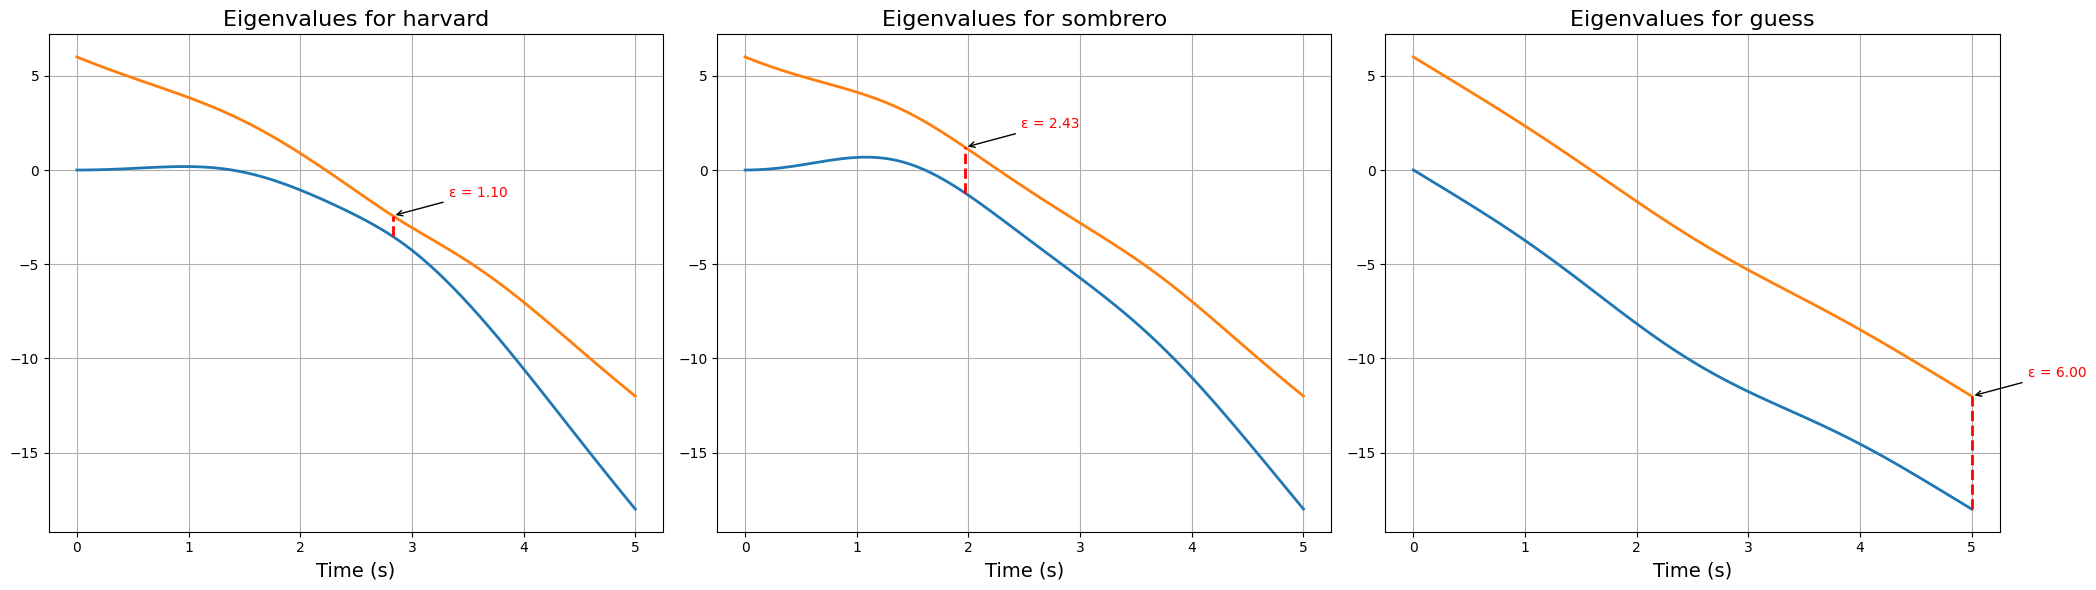

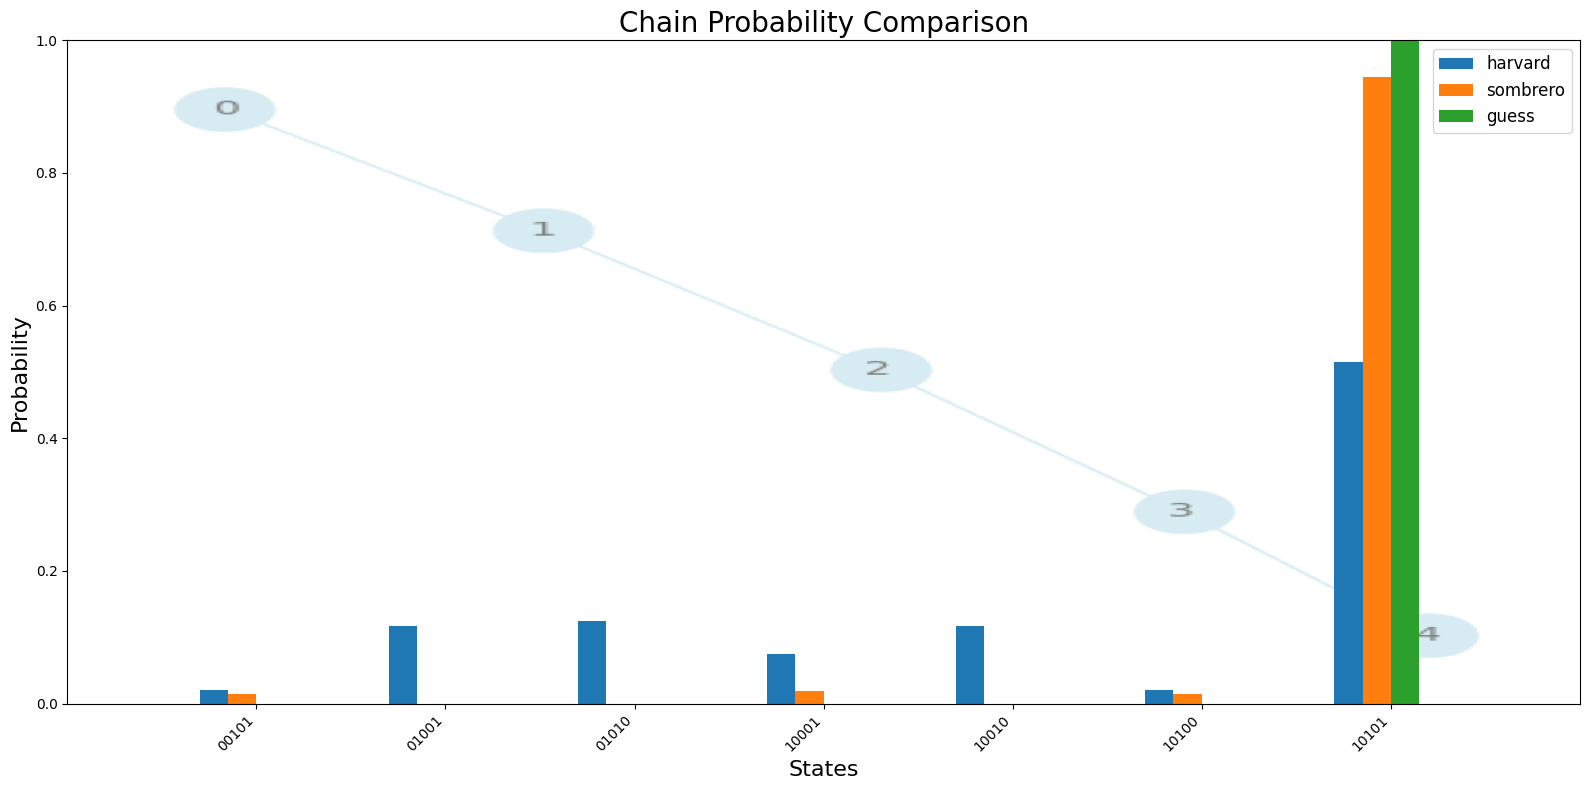

In [25]:
def greedy_independent_set(graph, degree_min):
    """
    Greedy algorithm to check if the given node is part of the independent set,
    considering the degree_min constraint.

    Parameters:
    graph (networkx.Graph): A NetworkX graph instance.
    node_index (int): The index of the node being checked.
    degree_min (float): The minimum degree a node must have to be considered.

    Returns:
    bool: True if the node is part of the independent set and satisfies degree_min, False otherwise.
    """
    independent_set = set()
    remaining_nodes = list(graph.nodes)
    
    # Greedy independent set construction
    while remaining_nodes:
        # Pick the first node from the remaining nodes
        node = remaining_nodes.pop(0)
        
        # Check if the node's degree satisfies the degree_min constraint
        if max(1, graph.degree[node]) >= degree_min:
            independent_set.add(node)
            
            # Remove all its neighbors from the remaining nodes
            neighbors = list(graph.neighbors(node))
            remaining_nodes = [n for n in remaining_nodes if n not in neighbors]
    
    # Return whether the specific node is in the independent set
    return independent_set

def greedy_guess(graph, node_index, degree_min):
    return node_index in greedy_independent_set(graph,degree_min)


hamiltonians_out,results_out = hamiltonians_constructor(init_params,chain_graph,greedy_guess)
plot_eigenvalues(init_params["taulist"], hamiltonians_out,N, M=2)
plot_probabilities(results_out, N, graph_type="Chain", graph=chain_graph, threshold=0.01)


---
# final points 

Clearly in simple cases we can see our solution helps. As a follow up we need to use another system instead of minimal gaps which will allow us to check a collection of graphs instead of testing them in an anecdotal way. 

In addition, the constants for the new hamiltonians were not optimized. Specificly the usage of $\delta$ and $\Delta_0$ in the final hamiltonian was a guess and is assumed to be improvable.

### Bad states probability 

The bad states are directly affected by the distance between the vertexes. We want the probability to be below a threshhold which seems fit. 


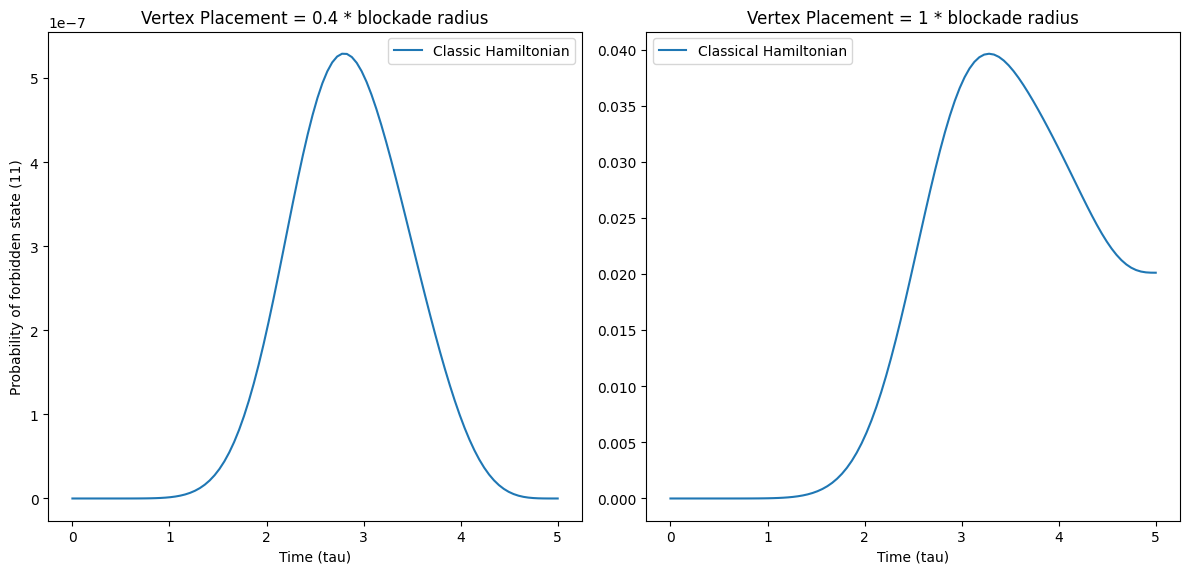

In [26]:
import matplotlib.pyplot as plt

# Function to track forbidden state probability over time
def track_forbidden_state(results_out, state_index):
    """
    Track the probability of a forbidden state over time.

    Parameters:
    - results_out: Dictionary with time-evolved state vectors
    - state_index: Index of the forbidden state (e.g., '11')
    
    Returns:
    - forbidden_probs: Dictionary with probabilities over time for each Hamiltonian type
    """
    forbidden_probs = {}
    
    # Loop through each type of Hamiltonian result (e.g., 'classical', 'guess', 'setup')
    for key, result in results_out.items():
        forbidden_probs[key] = []
        
        # Loop over all time steps
        for time_step in result.states:
            # Get the probability amplitude of the forbidden state at the current time step
            prob = np.abs(time_step.full()[state_index][0])**2  # Extract amplitude for the specific state
            forbidden_probs[key].append(prob)
    
    return forbidden_probs

# Simulation for vertex_placement = 0.4
init_params_0_4 = initialize_system_parameters(vertex_placement=0.4)
chain_graph_0_4 = ChainGraph(2)
chain_graph_0_4.create_graph()
hamiltonians_out_0_4, results_out_0_4 = hamiltonians_constructor(init_params_0_4, chain_graph_0_4,greedy_guess)
forbidden_probabilities_0_4 = track_forbidden_state(results_out_0_4, state_index=3)  # Track state '11'

# Simulation for vertex_placement = 1
init_params_1 = initialize_system_parameters(vertex_placement=1)
chain_graph_1 = ChainGraph(2)
chain_graph_1.create_graph()
hamiltonians_out_1, results_out_1 = hamiltonians_constructor(init_params_1, chain_graph_1,greedy_guess)
forbidden_probabilities_1 = track_forbidden_state(results_out_1, state_index=3)  # Track state '11'

# Plot the results side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for vertex_placement = 0.4
ax1.plot(init_params_0_4['taulist'], forbidden_probabilities_0_4['harvard'], label='Classic Hamiltonian')
ax1.set_title('Vertex Placement = 0.4 * blockade radius')
ax1.set_xlabel('Time (tau)')
ax1.set_ylabel('Probability of forbidden state (11)')
ax1.legend()

# Plot for vertex_placement = 1
ax2.plot(init_params_1['taulist'], forbidden_probabilities_1['harvard'], label='Classical Hamiltonian')
ax2.set_title('Vertex Placement = 1 * blockade radius')
ax2.set_xlabel('Time (tau)')
ax2.legend()

plt.tight_layout()  # Adjust spacing
plt.show()